In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")


In [26]:
data= pd.read_csv('Data-Melbourne_F_fixed.csv')
data.head()

,Serial No.,Average Outflow,Average Inflow,Energy Consumption,Ammonia,Biological Oxygen Demand,Chemical Oxygen Demand,Total Nitrogen,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure,Average humidity,Total rainfall,Average visibility,Average wind speed,Maximum wind speed,Year,Month,Day
0,0,2.941,2.589,175856,27.0,365.0,730.0,60.378,19.3,25.1,12.6,0.0,56,1.52,10.0,26.9,53.5,2014,1,1
1,1,2.936,2.961,181624,25.0,370.0,740.0,60.026,17.1,23.6,12.3,0.0,63,0.00,10.0,14.4,27.8,2014,1,2
2,2,2.928,3.225,202016,42.0,418.0,836.0,64.522,16.8,27.2,8.8,0.0,47,0.25,10.0,31.9,61.1,2014,1,5
3,3,2.928,3.354,207547,36.0,430.0,850.0,63.000,14.6,19.9,11.1,0.0,49,0.00,10.0,27.0,38.9,2014,1,6
4,4,2.917,3.794,202824,46.0,508.0,1016.0,65.590,13.4,19.1,8.0,0.0,65,0.00,10.0,20.6,35.2,2014,1,7


Handling missing values(if present)

In [27]:
missing_threshold = 0.2
for col in data.columns:
    if data[col].isnull().mean() > missing_threshold:
        data.drop(columns=[col], inplace=True)
    else:
        if data[col].dtype == 'object':
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)


In [28]:
correlation = data.corr()
correlation

,Serial No.,Average Outflow,Average Inflow,Energy Consumption,Ammonia,Biological Oxygen Demand,Chemical Oxygen Demand,Total Nitrogen,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure,Average humidity,Total rainfall,Average visibility,Average wind speed,Maximum wind speed,Year,Month,Day
Serial No.,1.000000,0.308471,0.378175,0.232384,0.121004,-0.241955,0.228638,0.095041,-0.034638,-0.045970,0.047995,0.027521,-0.075676,-0.207726,-0.039775,-0.022567,0.000486,0.983282,0.052026,0.017682
Average Outflow,0.308471,1.000000,0.541923,0.167099,0.040590,-0.115811,-0.022723,-0.061951,-0.000163,0.006070,0.035516,-0.068941,-0.016560,-0.090001,-0.027635,-0.015406,-0.006319,0.308915,-0.012221,-0.061292
Average Inflow,0.378175,0.541923,1.000000,0.136211,-0.032709,-0.121364,0.018026,-0.035827,0.098149,0.093073,0.140905,-0.012452,-0.040534,-0.100358,-0.031872,-0.025010,-0.012203,0.388505,-0.066273,-0.055009
Energy Consumption,0.232384,0.167099,0.136211,1.000000,-0.133076,-0.136945,0.000346,-0.167448,-0.266053,-0.245119,-0.222896,-0.004160,0.155245,-0.014242,0.007085,0.020656,0.017388,0.179876,0.272076,0.023010
Ammonia,0.121004,0.040590,-0.032709,-0.133076,1.000000,0.164753,0.284552,0.342995,0.110000,0.099279,0.094802,-0.032908,-0.076970,-0.074313,-0.028647,-0.047966,-0.048622,0.140567,-0.112396,-0.029223
Biological Oxygen Demand,-0.241955,-0.115811,-0.121364,-0.136945,0.164753,1.000000,0.524189,0.455843,0.150706,0.137368,0.133025,-0.011270,-0.087240,0.001186,-0.019039,0.001384,0.000370,-0.228753,-0.065866,-0.000713
Chemical Oxygen Demand,0.228638,-0.022723,0.018026,0.000346,0.284552,0.524189,1.000000,0.681225,0.083946,0.090018,0.052716,0.002585,-0.152655,-0.055335,-0.050351,-0.029496,-0.006580,0.231927,-0.034368,0.005837
Total Nitrogen,0.095041,-0.061951,-0.035827,-0.167448,0.342995,0.455843,0.681225,1.000000,0.269751,0.259386,0.232274,0.006595,-0.210108,-0.012618,-0.053080,-0.029228,0.006540,0.120105,-0.142140,-0.007392
Average Temperature,-0.034638,-0.000163,0.098149,-0.266053,0.110000,0.150706,0.083946,0.269751,1.000000,0.924944,0.890901,0.013499,-0.553688,-0.004256,-0.122247,0.098620,0.219791,0.015400,-0.272413,-0.009542
Maximum temperature,-0.045970,0.006070,0.093073,-0.245119,0.099279,0.137368,0.090018,0.259386,0.924944,1.000000,0.759461,0.018942,-0.533249,-0.003110,-0.120905,0.035349,0.199370,-0.004957,-0.223353,0.006459


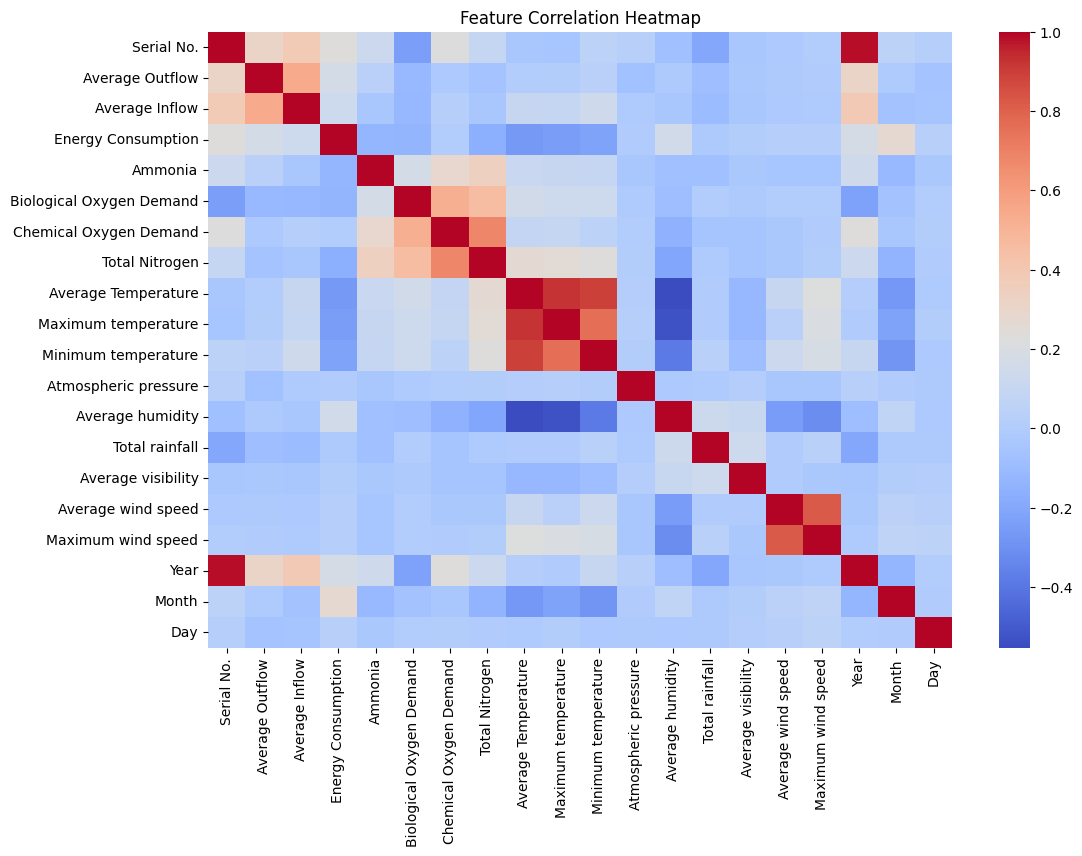

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

BOD and COD both are related to the wastewater treatment plant's effluent quality and they show strong correlation with other quantities. I'm choosing Chemical Oxygen Demand(COD) as my target variable.

In [30]:
threshold=data['Chemical Oxygen Demand'].median()
data['Chemical Oxygen Demand']=np.where(data['Chemical Oxygen Demand']>threshold,1,0)

In [31]:
x= data.drop('Chemical Oxygen Demand', axis=1)
y= data['Chemical Oxygen Demand']

In [32]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)


In [33]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y, test_size=0.2, random_state=42)

In [34]:
def model_eval(model,x_train,x_test,y_train,y_test):
 model.fit(x_train, y_train)
 y_pred= model.predict(x_test)
 accuracy= accuracy_score(y_test, y_pred)
 f1= f1_score(y_test, y_pred, average='weighted')
 conf_matrix= confusion_matrix(y_test, y_pred)
 print("Accuracy:", accuracy)
 print("F1 Score:", f1)
 print("Confusion Matrix:\n", conf_matrix)

Logistic Regression from Scratch

In [35]:
class LR:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []


    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):

        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def fit(self, X, y):
        n_samples, n_features = X.shape


        self.weights = np.zeros(n_features)
        self.bias = 0


        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            self.losses.append(self.compute_loss(y,A))
            dz = A - y

            dw = (1 / n_samples) * np.dot(X.T, dz)
            db = (1 / n_samples) * np.sum(dz)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        threshold = .5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]

        return np.array(y_predicted_cls)

In [36]:
regressor=LR(learning_rate=0.0001, n_iters=1000)
regressor.fit(x_train, y_train)
predictions=regressor.predict(x_test)

print("Test accuracy: {0:.3f}".format(accuracy_score(y_test, predictions)))
print("Confusion Matrix:",confusion_matrix(y_test, predictions))
print("F1 Score:",f1_score(y_test,predictions,average='weighted'))

Test accuracy: 0.783
Confusion Matrix: [[ 97  30]
 [ 30 120]]
F1 Score: 0.7833935018050542


Logistic Regression using sklearn

In [37]:
print("Logistic Regression\n")
model_lr=LogisticRegression()
model_eval(model_lr,x_train,x_test,y_train,y_test)

Logistic Regression

Accuracy: 0.8664259927797834
F1 Score: 0.866288999202105
Confusion Matrix:
 [[107  20]
 [ 17 133]]


In [38]:
print("K-Nearest Neighbors\n")
knn = KNeighborsClassifier(n_neighbors=5)
model_eval(knn, x_train, x_test, y_train, y_test)

K-Nearest Neighbors

Accuracy: 0.7689530685920578
F1 Score: 0.7692613729746272
Confusion Matrix:
 [[ 98  29]
 [ 35 115]]


In [39]:
print("Decision Tree\n")
dec_tree = DecisionTreeClassifier(random_state=42)
model_eval(dec_tree, x_train, x_test, y_train, y_test)

Decision Tree

Accuracy: 0.8447653429602888
F1 Score: 0.8448873683952137
Confusion Matrix:
 [[107  20]
 [ 23 127]]


In [40]:
print("Random Forest\n")
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_eval(rand_forest, x_train, x_test, y_train, y_test)

Random Forest

Accuracy: 0.8916967509025271
F1 Score: 0.8916967509025271
Confusion Matrix:
 [[112  15]
 [ 15 135]]


In [41]:
print("Support Vector Machine\n")
svm = SVC(kernel='rbf', random_state=42)
model_eval(svm, x_train, x_test, y_train, y_test)

Support Vector Machine

Accuracy: 0.851985559566787
F1 Score: 0.8519389120733147
Confusion Matrix:
 [[106  21]
 [ 20 130]]


Applying Hyperparameter tuning

In [42]:
print("\nLogistic Regression")
lr = LogisticRegression()
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(x_train, y_train)
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
model_eval(grid_search_lr.best_estimator_, x_train, x_test, y_train, y_test)


Logistic Regression
Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.8844765342960289
F1 Score: 0.8843123693710812
Confusion Matrix:
 [[109  18]
 [ 14 136]]


In [43]:
print("\nK-Nearest Neighbors")
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 9,11], 'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(x_train, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)
model_eval(grid_search_knn.best_estimator_, x_train, x_test, y_train, y_test)


K-Nearest Neighbors
Best Parameters for KNN: {'n_neighbors': 11, 'weights': 'uniform'}
Accuracy: 0.7870036101083032
F1 Score: 0.7873707253849984
Confusion Matrix:
 [[103  24]
 [ 35 115]]


In [44]:
print("\nDecision Tree")
dec_tree = DecisionTreeClassifier(random_state=42)
param_grid_dt = {'max_depth': [None, 10, 20, 30], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(dec_tree, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(x_train, y_train)
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)
model_eval(grid_search_dt.best_estimator_, x_train, x_test, y_train, y_test)


Decision Tree
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1}
Accuracy: 0.851985559566787
F1 Score: 0.8519389120733147
Confusion Matrix:
 [[106  21]
 [ 20 130]]


In [45]:
print("\nRandom Forest")
rand_forest = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30]}
grid_search_rf = GridSearchCV(rand_forest, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(x_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
model_eval(grid_search_rf.best_estimator_, x_train, x_test, y_train, y_test)


Random Forest
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.9025270758122743
F1 Score: 0.9024271075258603
Confusion Matrix:
 [[112  15]
 [ 12 138]]


We are getting the best accuracy of 90% using the Random forest model.